In [314]:
import faiss
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn import neighbors

# Data Prep

In [25]:
%%time
stuff = pd.read_csv("c2vpoint2m.txt.gz", sep="\t", header=None)

CPU times: user 20.6 s, sys: 1.56 s, total: 22.1 s
Wall time: 22.2 s


In [233]:
%%time
stuff2 = pd.read_csv("c2vpoint3m.txt.gz", sep="\t", header=None)

CPU times: user 44.7 s, sys: 11.8 s, total: 56.5 s
Wall time: 2min 25s


In [47]:
stuff.set_index(0, inplace=True)

In [34]:
%%time
cgan = pd.read_csv("activities.txt.gz", sep="\t")

In [35]:
egfr_activity = cgan[cgan['target'] == 'EGFR'].set_index('compound')

In [42]:
egfr_active = egfr_activity[egfr_activity['activity'] >= 6]
egfr_active_compounds = egfr_active.index.values

In [43]:
egfr_inactive = egfr_activity[egfr_activity['activity']  < 6]
egfr_inactive_compounds = egfr_inactive.index.values

In [37]:
egfr_features = pd.read_csv("egfr.c2v.txt", sep="\t", header=None).set_index(0)

In [41]:
egfr_compounds = egfr_features.index.values

In [61]:
egfr_active_features = egfr_features.loc[egfr_active_compounds]
egfr_inactive_features = egfr_features.loc[egfr_inactive_compounds]

In [178]:
min_max_scaler = preprocessing.MinMaxScaler()

In [193]:
egfr_active_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_active_features), 
                                         index=egfr_active_features.index)

In [192]:
egfr_inactive_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_inactive_features), 
                                           index=egfr_inactive_features.index)

In [58]:
len(list(set(stuff.index.values) & set(egfr_compounds)))

1113

In [59]:
stuff_cleaned = stuff.loc[list(set(stuff.index.values) - set(egfr_compounds))]

In [191]:
stuff_cleaned_norm = pd.DataFrame(min_max_scaler.fit_transform(stuff_cleaned), index=stuff_cleaned.index)

In [302]:
stuff_cleaned = stuff.drop_duplicates()

KeyboardInterrupt: 

In [200]:
all(i not in egfr_active_features_norm.index.values for i in stuff_cleaned_norm.index.values)

True

# Faiss Test

In [12]:
d = 64

In [13]:
nb = 100000

In [14]:
nq = 10000

In [15]:
np.random.seed(1234)

In [16]:
xb = np.random.random((nb, d)).astype('float32')

In [20]:
xb[:, 0] += np.arange(nb) / 1000.

In [303]:
xb

array([[1.9151945e-01, 6.2210876e-01, 4.3772775e-01, ..., 6.2491673e-01,
        4.7809380e-01, 1.9567518e-01],
       [3.8431743e-01, 5.3873684e-02, 4.5164841e-01, ..., 1.5139526e-01,
        3.3517465e-01, 6.5755177e-01],
       [7.7342540e-02, 5.5006396e-02, 3.2319480e-01, ..., 3.4441698e-01,
        6.4088041e-01, 1.2620533e-01],
       ...,
       [2.0080847e+02, 5.9024531e-01, 7.9889351e-01, ..., 3.3985901e-01,
        3.0194950e-01, 8.5385454e-01],
       [2.0066747e+02, 9.1606879e-01, 9.5507878e-01, ..., 5.9536433e-01,
        3.8491808e-02, 1.0563799e-01],
       [2.0085463e+02, 5.9113413e-01, 6.7890793e-01, ..., 2.1897699e-01,
        6.5301590e-02, 2.1753833e-01]], dtype=float32)

In [18]:
xq = np.random.random((nq, d)).astype('float32')

In [21]:
xq[:, 0] += np.arange(nq) / 1000.

In [27]:
index = faiss.IndexFlatL2(d)

In [228]:
index = faiss.IndexFlatIP(d)

In [242]:
index = faiss.IndexHNSWFlat(d, 32)

<faiss.swigfaiss.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7ffa030ba4b0> >

In [232]:
index.is_trained

True

In [97]:
print(index)

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7ffb5847ebd0> >


In [236]:
print(index.is_trained)

True


In [237]:
index.add(xb)

In [238]:
print(index.ntotal)

100000


In [239]:
k = 4

In [240]:
D, I = index.search(xb[:5], k)
print(I)
print(D)

[[  0  78 100 393]
 [  1 175 277 364]
 [  2 304 101  13]
 [  3 173  18 182]
 [  4 288  18 175]]
[[0.        7.269569  7.470868  7.527162 ]
 [0.        6.8936625 7.024329  7.2946835]
 [0.        6.1093006 6.4545927 7.283067 ]
 [0.        7.370055  7.5503116 7.7337513]
 [0.        7.0206275 7.553274  7.5589724]]


In [241]:
D, I = index.search(xq, k)     
print(I[:5])                   
print(I[-5:])                  

[[207 381 210 477]
 [142  72  64 300]
 [425 527 281 637]
 [196 184 164 181]
 [526 120 377 425]]
[[ 9900  9831 10048  9810]
 [10403 10260 10240 10473]
 [10164  9787 10089 10118]
 [10284 10203 10571 10632]
 [ 9628  9554 10036 10016]]


In [256]:
if []:
    print("yay")

In [135]:
arr = np.arange(9).reshape(3, 3)
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [137]:
arr2 = np.ascontiguousarray(arr, 'float32')
arr2

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]], dtype=float32)

In [162]:
test = egfr_active_features.sample(n=500, random_state=0)

In [164]:
all(i in egfr_active_features.index.values for i in test.index.values)

True

# Logic Creation

In [328]:
def knn(rest, sample_from, success, size, n_neighbors, algorithm, metric, seed):
    sizer = int(sample_from.shape[0] * size + .5)
    #print(size)
    query = sample_from.sample(n=sizer, random_state=seed)
    sub = list(set(sample_from.index.values) - set(query.index.values))
    act_without_query = sample_from.loc[sub]
    database = pd.concat([act_without_query]+rest)
    
    model = neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
    start = time.time()
    model.fit(database)
    end = time.time()
    time_to_build = end - start
    start = time.time()
    _, indices = model.kneighbors(query)
    #print(indices[:10])
    #print(distances[:10])
    end = time.time()
    time_to_query = end - start
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if database.index.values[j] in success.index.values:
                count += 1
        sum += count/float(n_neighbors)
    average = sum/query.shape[0]
    d = OrderedDict({'algorithm/index':[algorithm], 'n_neighbors':[n_neighbors], 'query size':[size], 'metric':[metric], 
                     'build time (s)':[time_to_build], 'query time (s)':[time_to_query], 'quality':[average], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

In [85]:
def dataprep(active, rest, size, seed):
    size = int(active.shape[0] * size + .5)
    query = active.sample(n=size, random_state=seed)
    sub = list(set(active.index.values) - set(query.index.values))
    active_minus_query = active.loc[sub]
    database = pd.concat([active_minus_query] + rest)#.astype('float32')
    
    return database, query

In [304]:
def buildFaissModel(database, n_neighbors, index_type, args):
    
    if args:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1], *args)
    else:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1])
 
    start = time.time()
    index.add(np.ascontiguousarray(database.values, 'float32'))
    end = time.time()
    
    build_time = end - start
    
    return index, build_time


In [222]:
def runQuery(model, query, k, db, success):
    
    start = time.time()
    distances, indices = model.search(np.ascontiguousarray(query.values, 'float32'), k)
    end = time.time()
    
    query_time = end - start
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if db.index.values[j] in success.index.values:
                count += 1
        sum += count / float(k)
    avg = sum / query.shape[0]
    
    return avg, query_time
    

In [309]:
def faissNN(active, rest, size, k, index_type, seed, args=[]):
    database, query = dataprep(active, rest, size, seed)
    model, build_time = buildFaissModel(database, k, index_type, args)
    avg, query_time = runQuery(model, query, k, database, active)
    
    d = OrderedDict({'algorithm/index':[index_type], 'n_neighbors':[k], 'query size':[size], 'build time (s)':[build_time], 
                     'query time (s)':[query_time], 'quality':[avg], 'seed':[seed]})
    
    return pd.DataFrame(data=d)
    

# Tests

In [334]:
TABLE_RAW = pd.DataFrame()
TABLE_NORM = pd.DataFrame()

In [335]:
temp = knn([stuff_cleaned, egfr_inactive_features], egfr_active_features, egfr_active, 
               0.2, 100, 'brute', 'euclidean', 0)
TABLE_RAW = pd.concat([TABLE_RAW, temp])

In [338]:
temp = knn([stuff_cleaned_norm, egfr_inactive_features_norm], egfr_active_features_norm, egfr_active, 0.2, 100, 'brute', 'euclidean', 0)

TABLE_NORM = pd.concat([TABLE_NORM, temp])

In [322]:
g = faissNN(egfr_active_features, [egfr_inactive_features, stuff_cleaned], 0.2, 100, 'FlatL2', 0)
g

,algorithm/index,n_neighbors,query size,build time (s),query time (s),quality,seed
0,FlatL2,100,0.2,1.017363,0.94189,0.236847,0


In [194]:
faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], 0.2, 100, 'FlatIP', 0)

,index,n_neighbors,build time (s),query time (s),quality
0,FlatIP,100,1.086015,2.128519,0.997519


In [323]:
g = faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], 0.2, 100, 'FlatL2', 0)
g

,algorithm/index,n_neighbors,query size,build time (s),query time (s),quality,seed
0,FlatL2,100,0.2,1.056752,0.724189,0.998022,0


In [260]:
faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], 0.2, 100, 'HNSWFlat', 0, [32])

,index,n_neighbors,build time (s),query time (s),quality
0,HNSWFlat,100,36.900793,0.020056,0.9975


In [265]:
foo = []
for n in range(40, 240, 40):
    foo.append(faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], 0.2, n, 'FlatL2', 0))

In [272]:
a = pd.concat(foo)
a

,index,n_neighbors,build time (s),query time (s),quality
0,FlatL2,40,0.990923,0.715928,0.997854
0,FlatL2,80,0.913530,0.692116,0.997994
0,FlatL2,120,0.901195,0.692259,0.998057
0,FlatL2,160,0.907972,0.690939,0.998088
0,FlatL2,200,0.941866,0.707465,0.998106


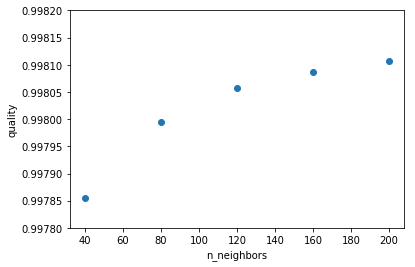

In [277]:
plt.figure()
plt.scatter(a['n_neighbors'], a['quality'])
plt.xlabel('n_neighbors')
plt.ylabel('quality')
plt.ylim(0.9978, 0.9982)
plt.show()

In [288]:
bar = []
for prop in np.arange(0.5, 0, -0.05):
    bar.append(faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], prop, 100, 'FlatL2', 0))

In [289]:
b = pd.concat(bar)
b

,index,n_neighbors,query size,build time (s),query time (s),quality
0,FlatL2,100,0.50,1.082225,1.920226,0.998193
0,FlatL2,100,0.45,1.039547,1.804904,0.998830
0,FlatL2,100,0.40,1.049870,1.433945,0.998786
0,FlatL2,100,0.35,1.097750,1.672957,0.998613
0,FlatL2,100,0.30,1.048418,1.092378,0.998555
0,FlatL2,100,0.25,0.951591,0.892275,0.998269
0,FlatL2,100,0.20,0.967994,0.790984,0.998022
0,FlatL2,100,0.15,0.893539,0.528824,0.999751
0,FlatL2,100,0.10,1.013566,0.411136,1.000000
0,FlatL2,100,0.05,0.997247,0.284062,1.000000


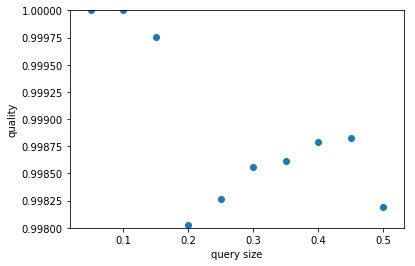

In [290]:
plt.figure()
plt.scatter(b['query size'], b['quality'])
plt.xlabel('query size')
plt.ylabel('quality')
plt.ylim(0.998, 1)
plt.show()

In [306]:
foo = []
for index in ['FlatL2', 'FlatIP']:
    for seed in range(5):
        foo.append(faissNN(egfr_active_features_norm, [egfr_inactive_features_norm, stuff_cleaned_norm], 0.2, 100, index, seed))


In [307]:
c = pd.concat(foo)
c

,index,n_neighbors,query size,build time (s),query time (s),quality,seed
0,FlatL2,100,0.2,1.001927,0.870405,0.998022,0
0,FlatL2,100,0.2,1.665274,1.108037,0.996231,1
0,FlatL2,100,0.2,1.055483,0.799595,0.997836,2
0,FlatL2,100,0.2,1.030599,0.776447,0.998507,3
0,FlatL2,100,0.2,1.289508,0.892762,0.998433,4
0,FlatIP,100,0.2,1.369143,1.110771,0.997519,0
0,FlatIP,100,0.2,1.518715,0.942178,0.996045,1
0,FlatIP,100,0.2,1.115853,0.759523,0.997369,2
0,FlatIP,100,0.2,1.040860,0.705303,0.999608,3
0,FlatIP,100,0.2,1.040643,0.667181,0.999384,4


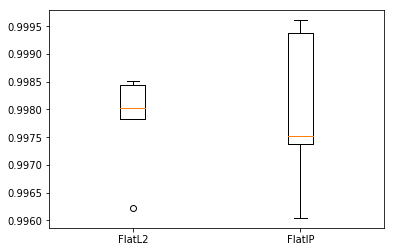

In [308]:
plt.figure()
plt.boxplot([c['quality'][:5], c['quality'][5:]])
plt.xticks([1, 2] ,['FlatL2', 'FlatIP'])
plt.show()